# Setup

In [1]:
import numpy as np
import scipy.io
import sklearn
import sklearn.datasets
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Helper Functions

- Activation functions

In [2]:
def sigmoid(x):
    return 1./(1 + np.exp(-x))

In [3]:
def relu(x):
    return np.maximum(0, x)

- Modules

Application of 3-layer NN

In [4]:
def initialize_params_he(layers_dims):
    
    np.random.seed(3)
    params = {}
    L = len(layers_dims) - 1
    
    for l in range(1, L+1):
        params['W' + str(l)] = np.random.randn(layers_dims[l], layers_dims[l-1]) * np.sqrt(2./layers_dims[l-1])
        params['b' + str(l)] = np.zeros((layers_dims[l], 1))
    
    return params

In [5]:
def forward_propagation(X, params):
    
    # Retrieve params
    W1 = params['W1']
    b1 = params['b1']
    W2 = params['W2']
    b2 = params['b2']
    W3 = params['W3']
    b3 = params['b3']
    
    # LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID
    Z1 = np.dot(W1, X) + b1
    A1 = relu(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = relu(Z2)
    Z3 = np.dot(W3, A2) + b3
    A3 = sigmoid(Z3)
    
    cache = (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3)
    
    return A3, cache

In [6]:
def compute_cost_total(A3, Y):
    
    logprobs = -(Y * np.log(A3) + (1 - Y) * np.log(1 - A3))
    cost = np.nansum(logprobs)
    
    return cost

In [7]:
def backward_propagation(X, Y, cache):
    
    m = X.shape[1]
    (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3) = cache
    
    dZ3 = A3 - Y
    dW3 = 1./m * np.dot(dZ3, A2.T)
    db3 = 1./m * np.sum(dZ3, axis=1, keepdims=True)
    dA2 = np.dot(W3.T, dZ3)
    
    dZ2 = np.multiply(dA2, np.int64(A2 > 0))
    dW2 = 1./m * np.dot(dZ2, A1.T)
    db2 = 1./m * np.sum(dZ2, axis=1, keepdims=True)
    dA1 = np.dot(W2.T, dZ2)
    
    dZ1 = np.multiply(dA1, np.int64(A1 > 0))
    dW1 = 1./m * np.dot(dZ1, X.T)
    db1 = 1./m * np.sum(dZ1, axis=1, keepdims=True)
    
    grads = {'dZ3': dZ3, 'dW3': dW3, 'db3': db3,
             'dZ2': dZ2, 'dW2': dW2, 'db2': db2, 'dA2': dA2,
             'dZ1': dZ1, 'dW1': dW1, 'db1': db1, 'dA1': dA1}
    
    return grads

In [8]:
def predict(X, Y, params):
    
    m = X.shape[1]
    
    A3, _ = forward_propagation(X, params)
    
    p = (A3 > 0.5).astype(int)
    print('Accuracy: ' + str(np.sum(p == Y)/m))
    
    return p

- Data

In [9]:
def load_dataset():
    
    np.random.seed(3)
    train_X, train_Y = sklearn.datasets.make_moons(n_samples=300, noise=.2) #300 #0.2 
    
    # Visualize the data
    plt.scatter(train_X[:, 0], train_X[:, 1], c=train_Y, s=40, cmap=plt.cm.Spectral);
    train_X = train_X.T
    train_Y = train_Y.reshape((1, train_Y.shape[0]))
    
    return train_X, train_Y

- Visualization

In [10]:
def plot_decision_boundary(model, X, y):
    
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y[0, :], cmap=plt.cm.Spectral)
    plt.show()

In [11]:
def predict_dec(X, params):
    
    A3, _ = forward_propagation(X, params)
    
    return (A3 > 0.5)

# Optimization Algorithms

- Gradient Descent

In [12]:
def update_GD(params, grads, lr):
    '''
    Implement an update step using Gradient Descent
    '''
    
    L = len(params)//2
    
    for l in range(1, L+1):
        params['W' + str(l)] -= lr * grads['dW' + str(l)]
        params['b' + str(l)] -= lr * grads['db' + str(l)]
    
    return params

- Momentum

In [13]:
def initialize_v(params):
    '''
    Initialize the velocity (first gradient) dictionary:
        - keys: 'dW1', 'db1', ..., 'dWL', 'dbL'
        - values: numpy arrays of zeros of the same shape as the corresponding parameters
    '''
    
    L = len(params)//2
    v = {}
    
    for l in range(1, L+1):
        v['dW' + str(l)] = np.zeros((params['W' + str(l)].shape[0], params['W' + str(l)].shape[1]))
        v['db' + str(l)] = np.zeros((params['b' + str(l)].shape[0], params['b' + str(l)].shape[1]))
    
    return v

In [14]:
def update_Momentum(params, grads, v, lr, beta=0.9):
    '''
    Implement an update step using Momentum
    '''
    
    L = len(params)//2
    
    for l in range(1, L+1):
        v['dW' + str(l)] = beta * v['dW' + str(l)] + (1 - beta) * grads['dW' + str(l)]
        v['db' + str(l)] = beta * v['db' + str(l)] + (1 - beta) * grads['db' + str(l)]
        
        params['W' + str(l)] -= lr * v['dW' + str(l)]
        params['b' + str(l)] -= lr * v['db' + str(l)]
    
    return params

- RMSprop

In [15]:
def initialize_s(params):
    '''
    Initialize the second gradient dictionary:
        - keys: 'dW1', 'db1', ..., 'dWL', 'dbL'
        - values: numpy arrays of zeros of the same shape as the corresponding parameters
    '''
    
    L = len(params)//2
    s = {}
    
    for l in range(1, L+1):
        s['dW' + str(l)] = np.zeros((params['W' + str(l)].shape[0], params['W' + str(l)].shape[1]))
        s['db' + str(l)] = np.zeros((params['b' + str(l)].shape[0], params['b' + str(l)].shape[1]))
    
    return s

In [16]:
def update_RMS(params, grads, s, lr, beta=0.99, epsilon=1e-8):
    '''
    Implement an update step using RMSprop
    '''
    
    L = len(params)//2
    
    for l in range(1, L+1):
        s['dW' + str(l)] = beta * s['dW' + str(l)] + (1 - beta) * np.power(grads['dW' + str(l)], 2)
        s['db' + str(l)] = beta * s['db' + str(l)] + (1 - beta) * np.power(grads['db' + str(l)], 2)
        
        params['W' + str(l)] -= lr * grads['dW' + str(l)]/(np.sqrt(s['dW' + str(l)]) + epsilon)
        params['b' + str(l)] -= lr * grads['db' + str(l)]/(np.sqrt(s['db' + str(l)]) + epsilon)
    
    return params

- Adam

In [17]:
def update_Adam(params, grads, v, s, t, lr, beta1=0.9, beta2=0.99, epsilon=1e-8):
    
    L = len(params)//2
    v_corrected = {}
    s_corrected = {}
    
    for l in range(1, L+1):
        v['dW' + str(l)] = beta1 * v['dW' + str(l)] + (1 - beta1) * grads['dW' + str(l)]
        v['db' + str(l)] = beta1 * v['db' + str(l)] + (1 - beta1) * grads['db' + str(l)]
        s['dW' + str(l)] = beta2 * s['dW' + str(l)] + (1 - beta2) * np.power(grads['dW' + str(l)], 2)
        s['db' + str(l)] = beta2 * s['db' + str(l)] + (1 - beta2) * np.power(grads['db' + str(l)], 2)
        
        # Bias correction
        v_corrected['dW' + str(l)] = v['dW' + str(l)]/(1 - np.power(beta1, t))
        v_corrected['db' + str(l)] = v['db' + str(l)]/(1 - np.power(beta1, t))
        s_corrected['dW' + str(l)] = s['dW' + str(l)]/(1 - np.power(beta2, t))
        s_corrected['db' + str(l)] = s['db' + str(l)]/(1 - np.power(beta2, t))
        
        params['W' + str(l)] -= lr * v_corrected['dW' + str(l)]/(np.sqrt(s_corrected['dW' + str(l)]) + epsilon)
        params['b' + str(l)] -= lr * v_corrected['db' + str(l)]/(np.sqrt(s_corrected['db' + str(l)]) + epsilon)
    
    return params

# Implementation

- Batch Gradient Descent

In [18]:
def BGD(X, Y, params, lr, epochs, print_cost=True):
    '''
    Implement Batch Gradient Descent optimization
    '''
    
    m = X.shape[1]
    costs = []
    
    for i in range(epochs):
        
        # forward propagation
        A3, cache = forward_propagation(X, params)
        
        # cost
        cost = compute_cost_total(A3, Y)
        
        # backward propagation
        grads = backward_propagation(X, Y, cache)
        
        # update
        params = update_GD(params, grads, lr)
        
        if print_cost and i % 1000 == 0:
            print('Cost after epoch %i: %f' % (i, cost/m))
        if print_cost and i % 100 == 0:
            costs.append(cost/m)
    
    return params, costs

- Stochastic Gradient Descent

In [19]:
def SGD(X, Y, params, lr, epochs, print_cost=True):
    '''
    Implement Stochastic Gradient Descent optimization
    '''
    
    m = X.shape[1]
    costs = []
    
    for i in range(epochs):
        
        cost = 0
        
        for j in range(m):
            
            # random idx
            idx = np.random.randint(m)
            Xi = X[:, idx:(idx+1)]
            Yi = Y[:, idx:(idx+1)]
            
            # forward propagation
            A3, cache = forward_propagation(Xi, params)
            
            # cost
            cost += compute_cost_total(A3, Yi)
            
            # backward propagation
            grads = backward_propagation(Xi, Yi, cache)
            
            # update
            params = update_GD(params, grads, lr)
        
        if print_cost and i % 1000 == 0:
            print('Cost after epoch %i: %f' % (i, cost/m))
        if print_cost and i % 100 == 0:
            costs.append(cost/m)
    
    return params, costs

- Mini-batch Gradient Descent

In [20]:
def random_mini_batches(X, Y, batch_size=64, seed=0):
    '''
    Generate a list of random mini-batches from (X, Y)
    '''
    
    np.random.seed(seed)
    m = X.shape[1]
    mini_batches = []
    
    # Shuffle (X, Y)
    shuffle = list(np.random.permutation(m))
    shuffled_X = X[:, shuffle]
    shuffled_Y = Y[:, shuffle]
    
    # Partition
    n = m//batch_size
    for k in range(n):
        mini_batch_X = shuffled_X[:, k * batch_size: (k+1) * batch_size]
        mini_batch_Y = shuffled_Y[:, k * batch_size: (k+1) * batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    if m % batch_size != 0:
        mini_batch_X = shuffled_X[:, n * batch_size:]
        mini_batch_Y = shuffled_Y[:, n * batch_size:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [21]:
def mini_batch_GD(X, Y, params, optimizer, lr, batch_size=64, epochs=10000, 
                  beta1=0.9, beta2=0.99, epsilon=1e-8, print_cost=True):
    '''
    Implement Mini-batch Gradient Descent optimization using different optimizer
        - optimier: 'gd': Gradient Descent;
                    'momentum': Momentum;
                    'rms': RMSprop;
                    'adam': Adam
        - beta1: Exponential decay hyperparameter for the first moment estimates
        - beta2: Exponential decay hyperparameter for the second moment estimates
    '''
    
    m = X.shape[1]
    costs = []
    seed = 10
    t = 0
    
    # Initialize the optimizer
    if optimizer == 'gd':
        pass
    elif optimizer == 'momentum':
        v = initialize_v(params)
    elif optimizer == 'rms':
        s = initialize_s(params)
    elif optimizer == 'adam':
        v = initialize_v(params)
        s = initialize_s(params)
    
    # Optimization Loop
    for i in range(epochs):
        
        seed += 1
        mini_batches = random_mini_batches(X, Y, batch_size, seed)
        cost = 0
        
        for mini_batch in mini_batches:
            
            # select a mini-batch
            mini_batch_X, mini_batch_Y = mini_batch
            
            # forward propagation
            A3, cache = forward_propagation(mini_batch_X, params)
            
            # cost
            cost += compute_cost_total(A3, mini_batch_Y)
            
            # backward propagation
            grads = backward_propagation(mini_batch_X, mini_batch_Y, cache)
            
            # update
            if optimizer == 'gd':
                params = update_GD(params, grads, lr)
            elif optimizer == 'momentum':
                params = update_Momentum(params, grads, v, lr, beta1)
            elif optimizer == 'rms':
                params = update_RMS(params, grads, s, lr, beta2)
            elif optimizer == 'adam':
                t += 1
                params = update_Adam(params, grads, v, s, t, lr, beta1, beta2, epsilon)
        
        if print_cost and i % 1000 == 0:
            print('Cost after epoch %i: %f' % (i, cost/m))
        if print_cost and i % 100 == 0:
            costs.append(cost/m)
    
    return params, costs

# Experiment

- Data Overview

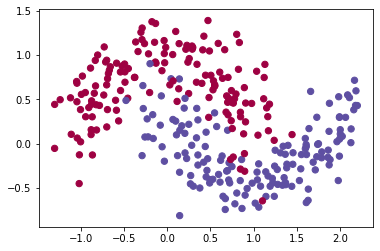

In [22]:
train_X, train_Y = load_dataset()

- Model: 3-layer neural network

In [23]:
def model(X, Y, layers_dims, optimizer, lr=0.0007, batch_size=64, epochs=10000,
          beta1=0.9, beta2=0.99, epsilon=1e-8, print_cost=True):
    '''
    Implement a 3-laer neural network with different optimization methods
    '''
    
    # Initialize parameters
    params = initialize_params_he(layers_dims)
    
    # Run
    if optimizer == 'bgd':
        params, costs = BGD(X, Y, params, lr, epochs)
    elif optimizer == 'sgd':
        params, costs = SGD(X, Y, params, lr, epochs)
    else:
        params, costs = mini_batch_GD(X, Y, params, optimizer, lr, batch_size,
                                      epochs, beta1, beta2, epsilon)
    
    # Plot costs
    plt.plot(costs)
    plt.ylabel('Cost')
    plt.xlabel('Epochs (x100)')
    plt.title('Learning rate = ' + str(lr))
    plt.show()
    
    return params

In [24]:
layers_dims = [train_X.shape[0], 5, 2, 1]

1) BGD

Cost after epoch 0: 0.702414
Cost after epoch 1000: 0.694312
Cost after epoch 2000: 0.687147
Cost after epoch 3000: 0.680783
Cost after epoch 4000: 0.674570
Cost after epoch 5000: 0.668099
Cost after epoch 6000: 0.661545
Cost after epoch 7000: 0.655195
Cost after epoch 8000: 0.648970
Cost after epoch 9000: 0.642384


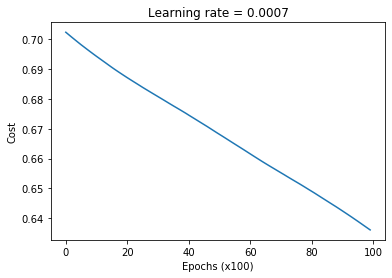

Accuracy: 0.66


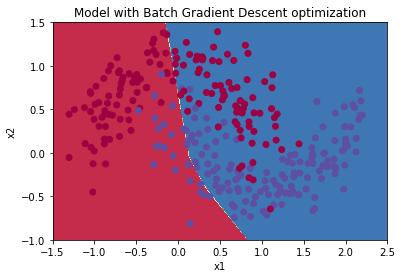

In [25]:
parameters = model(train_X, train_Y, layers_dims, optimizer = "bgd")

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Batch Gradient Descent optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(x.T, parameters), train_X, train_Y)

2) SGD

Cost after epoch 0: 0.694028
Cost after epoch 1000: 0.122123
Cost after epoch 2000: 0.128102
Cost after epoch 3000: 0.084004
Cost after epoch 4000: 0.076419
Cost after epoch 5000: 0.126330
Cost after epoch 6000: 0.083000
Cost after epoch 7000: 0.150516
Cost after epoch 8000: 0.118172
Cost after epoch 9000: 0.115783


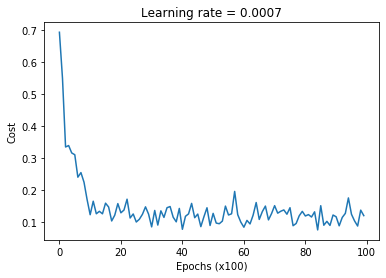

Accuracy: 0.9533333333333334


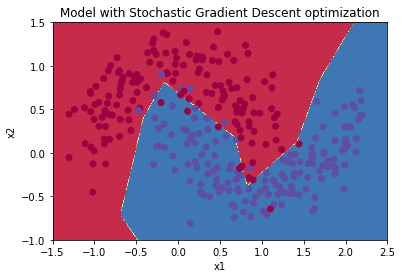

In [26]:
parameters = model(train_X, train_Y, layers_dims, optimizer = "sgd")

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Stochastic Gradient Descent optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(x.T, parameters), train_X, train_Y)

3) Mini-batch GD

Cost after epoch 0: 0.702405
Cost after epoch 1000: 0.668101
Cost after epoch 2000: 0.635288
Cost after epoch 3000: 0.600491
Cost after epoch 4000: 0.573367
Cost after epoch 5000: 0.551977
Cost after epoch 6000: 0.532370
Cost after epoch 7000: 0.514007
Cost after epoch 8000: 0.496472
Cost after epoch 9000: 0.468014


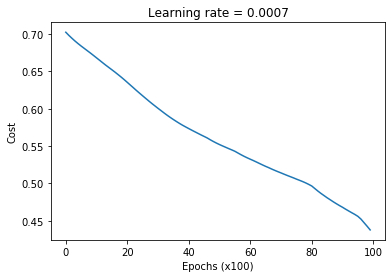

Accuracy: 0.7966666666666666


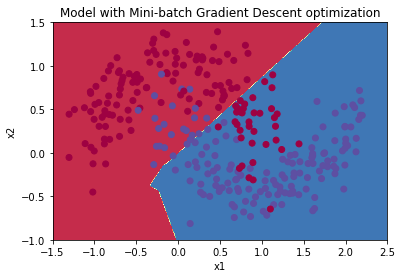

In [27]:
parameters = model(train_X, train_Y, layers_dims, optimizer = "gd")

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Mini-batch Gradient Descent optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(x.T, parameters), train_X, train_Y)

4) Momentum

Cost after epoch 0: 0.702413
Cost after epoch 1000: 0.668167
Cost after epoch 2000: 0.635388
Cost after epoch 3000: 0.600591
Cost after epoch 4000: 0.573444
Cost after epoch 5000: 0.552058
Cost after epoch 6000: 0.532458
Cost after epoch 7000: 0.514101
Cost after epoch 8000: 0.496652
Cost after epoch 9000: 0.468160


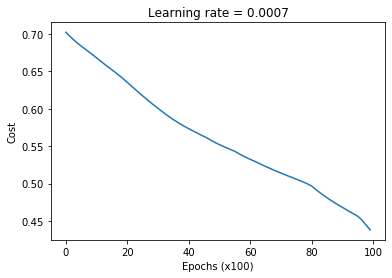

Accuracy: 0.7966666666666666


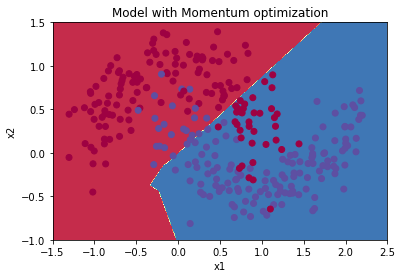

In [28]:
parameters = model(train_X, train_Y, layers_dims, optimizer = "momentum")

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Momentum optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(x.T, parameters), train_X, train_Y)

5) RMS

Cost after epoch 0: 0.700530
Cost after epoch 1000: 0.159894
Cost after epoch 2000: 0.140505
Cost after epoch 3000: 0.137233
Cost after epoch 4000: 0.135013
Cost after epoch 5000: 0.132286
Cost after epoch 6000: 0.130956
Cost after epoch 7000: 0.130616
Cost after epoch 8000: 0.130086
Cost after epoch 9000: 0.129395


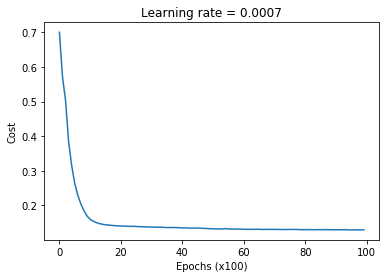

Accuracy: 0.94


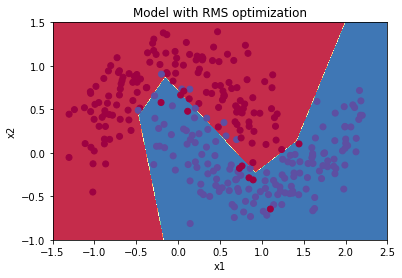

In [29]:
parameters = model(train_X, train_Y, layers_dims, optimizer = "rms")

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with RMS optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(x.T, parameters), train_X, train_Y)

5) Adam

Cost after epoch 0: 0.702165
Cost after epoch 1000: 0.161541
Cost after epoch 2000: 0.140212
Cost after epoch 3000: 0.137031
Cost after epoch 4000: 0.134611
Cost after epoch 5000: 0.131883
Cost after epoch 6000: 0.130716
Cost after epoch 7000: 0.130059
Cost after epoch 8000: 0.129524
Cost after epoch 9000: 0.129077


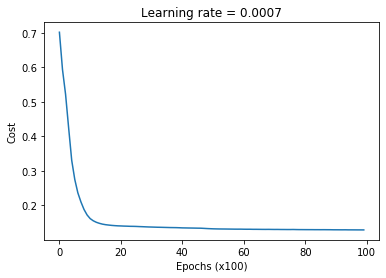

Accuracy: 0.94


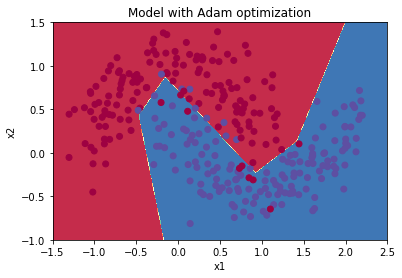

In [30]:
parameters = model(train_X, train_Y, layers_dims, optimizer = "adam")

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Adam optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(x.T, parameters), train_X, train_Y)